# 💳 Credit Card Customer Satisfaction

<img src='https://drive.google.com/uc?export=download&id=1rbKKOLallyz3ZK43HPCX589-PtcLRovf'>

From *bank data on credit card customer satisfaction*, let's try to predict if a given customer is about to leave the bank services.

Then the company can react by improving their service quality and keep the client.

# Getting Started

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = None

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

In [2]:
data = pd.read_csv('../input/credit-card-customers/BankChurners.csv')
data = data.drop(['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
         'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
         axis=1)
data

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,3,2,3,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462
10123,710638233,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,4,2,3,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511
10124,716506083,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,5,3,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000
10125,717406983,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,4,3,3,5281.0,0,5281.0,0.535,8395,62,0.722,0.000


# Data Analysis

In [3]:
# Values distribution
CAT_COLS = ['Attrition_Flag', 'Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
for column in CAT_COLS:
    print(data[column].value_counts(), '\n-----------------------------------')

Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64 
-----------------------------------
F    5358
M    4769
Name: Gender, dtype: int64 
-----------------------------------
Graduate         3128
High School      2013
Unknown          1519
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: Education_Level, dtype: int64 
-----------------------------------
Married     4687
Single      3943
Unknown      749
Divorced     748
Name: Marital_Status, dtype: int64 
-----------------------------------
Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
Unknown           1112
$120K +            727
Name: Income_Category, dtype: int64 
-----------------------------------
Blue        9436
Silver       555
Gold         116
Platinum      20
Name: Card_Category, dtype: int64 
-----------------------------------


The target *Attrition_Flag* is unbalanced since there are only 16% of attrited customers. Let's keep this in mind, but it should be fine like this.

# Preprocessing

In [4]:
def preprocess_inputs(df):
    df = df.copy()
    
    # Drop client number
    df = df.drop('CLIENTNUM', axis=1)
    
    # Encode targets
    df['Attrition_Flag'] = df['Attrition_Flag'].map({'Existing Customer': 0, 'Attrited Customer': 1})
    
    # Encode genders
    df['Gender'] = df['Gender'].map({'F': 0, 'M': 1})
    
    # Encode card categories
    df['Card_Category'] = df['Card_Category'].map({'Blue': 0, 'Silver': 1, 'Gold': 2, 'Platinum': 3})
    
    # Encode income categories
    df['Income_Category'] = df['Income_Category'].map({
        'Less than $40K': 0,
        '$40K - $60K': 1,
        '$80K - $120K': 2,
        '$60K - $80K': 3,
        '$120K +': 4,
        'Unknown': np.nan # this unknown value must be filled in with a knn imputer
    })
    
    # One-hot encode education level
    df = pd.concat([df, pd.get_dummies(df['Education_Level'], prefix='edu')], axis=1)
    df = df.drop('Education_Level', axis=1)
    
    # One-hot encode marital status
    df = pd.concat([df, pd.get_dummies(df['Marital_Status'], prefix='rel')], axis=1)
    df = df.drop('Marital_Status', axis=1)
    
    # Fill in missing incomes
    imputer = KNNImputer()
    df = pd.DataFrame(imputer.fit_transform(df), index=df.index, columns=df.columns)
    df['Income_Category'] = df['Income_Category'].apply(lambda x: np.round(x))
    
    # Split X and y
    X = df.drop('Attrition_Flag', axis=1)
    y = df['Attrition_Flag']
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=0)
    
    # Scale X
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
    
    return X_train, X_test, y_train, y_test

In [5]:
X_train, X_test, y_train, y_test = preprocess_inputs(data)
X_train

,Customer_Age,Gender,Dependent_count,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,edu_College,edu_Doctorate,edu_Graduate,edu_High School,edu_Post-Graduate,edu_Uneducated,edu_Unknown,rel_Divorced,rel_Married,rel_Single,rel_Unknown
147,1.079857,1.053392,-0.270660,2.022578,-0.248838,1.762645,-0.521645,-0.337332,-2.206526,0.243768,0.456652,0.202713,2.541650,-0.822570,-1.309885,1.196172,-0.475576,-0.332853,-0.215024,1.493771,-0.495135,-0.235303,-0.412911,-0.422694,-0.284855,1.074220,-0.797229,-0.27873
1985,-1.798572,1.053392,-1.815847,0.492351,-0.248838,-1.123839,1.406791,0.646017,0.489156,0.059522,-1.417863,0.187119,0.225400,-0.548518,0.139652,-0.976667,-0.988462,-0.332853,-0.215024,1.493771,-0.495135,-0.235303,-0.412911,-0.422694,-0.284855,-0.930908,1.254344,-0.27873
8316,-1.423125,-0.949314,1.274527,-0.272762,-0.248838,-1.374838,-1.164457,0.646017,-0.409405,-0.583800,-0.701495,-0.520766,-0.408378,0.217352,0.651254,-0.044261,-0.355539,-0.332853,-0.215024,-0.669447,-0.495135,-0.235303,2.421829,-0.422694,-0.284855,1.074220,-0.797229,-0.27873
2841,-0.797379,-0.949314,-0.270660,-1.037876,-0.248838,0.005655,-0.521645,-1.320680,-1.307966,-0.395602,1.481778,-0.529002,0.284674,-0.601855,-0.329316,-0.714428,0.710246,-0.332853,-0.215024,-0.669447,-0.495135,-0.235303,-0.412911,2.365778,-0.284855,1.074220,-0.797229,-0.27873
5824,-0.171634,-0.949314,1.274527,-0.272762,-0.248838,0.005655,0.763979,-0.337332,-1.307966,-0.631124,1.306042,-0.748747,0.448817,-0.220541,0.608620,-0.552089,1.765118,-0.332853,-0.215024,-0.669447,2.019653,-0.235303,-0.412911,-0.422694,-0.284855,1.074220,-0.797229,-0.27873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9225,-2.048870,1.053392,-1.815847,1.257465,-0.248838,-2.002335,-1.807269,0.646017,0.489156,1.654048,0.228440,1.633747,0.918451,2.575668,1.631823,0.138890,-0.781125,-0.332853,-0.215024,-0.669447,-0.495135,-0.235303,-0.412911,2.365778,-0.284855,-0.930908,1.254344,-0.27873
4859,0.454112,1.053392,-0.270660,1.257465,-0.248838,0.884150,0.121167,0.646017,0.489156,-0.473011,-0.634374,-0.416000,0.252757,-0.161310,0.693887,0.043152,-0.457388,-0.332853,-0.215024,-0.669447,-0.495135,-0.235303,2.421829,-0.422694,-0.284855,-0.930908,1.254344,-0.27873
3264,1.705603,1.053392,-1.043254,1.257465,-0.248838,1.762645,0.121167,0.646017,-2.206526,0.219831,0.766631,0.150879,1.009642,-0.084988,0.097019,0.838194,-0.381001,-0.332853,-0.215024,-0.669447,-0.495135,-0.235303,-0.412911,2.365778,-0.284855,-0.930908,1.254344,-0.27873
9845,0.579261,1.053392,0.501933,2.022578,-0.248838,0.507652,-0.521645,0.646017,-0.409405,2.835064,0.383429,2.800999,0.015660,2.876536,2.313958,0.263766,-0.832050,3.004329,-0.215024,-0.669447,-0.495135,-0.235303,-0.412911,-0.422694,-0.284855,1.074220,-0.797229,-0.27873


Now the data is preprocessed, let's train different algorithms to compare them.

# Training

In [6]:
models = {
    "      KNN" : KNeighborsClassifier(),
    "     Tree" : DecisionTreeClassifier(),
    "       RF" : RandomForestClassifier(),
    "GradBoost" : GradientBoostingClassifier(),
    "  XGBoost" : XGBClassifier(),
    " LightGBM" : LGBMClassifier(),
    " CatBoost" : CatBoostClassifier(verbose=0)
}
print("---- Training ---")
for name, model in models.items():
    model.fit(X_train, y_train)
    print(name + " fitted.")
print("----- Done! -----")

---- Training ---
      KNN fitted.
     Tree fitted.
       RF fitted.
GradBoost fitted.
  XGBoost fitted.
 LightGBM fitted.
 CatBoost fitted.
----- Done! -----


Let's display the results with the usuall metrics for binary classification.

In [7]:
results = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    print(name + ":  Accuracy = {:.2f}".format(accuracy_score(y_test, y_pred)))
    print("            F1 Score = {:.2f}".format(f1_score(y_test, y_pred)))
    print("              Recall = {:.2f}".format(recall_score(y_test, y_pred)))
    print("           Precision = {:.2f}".format(precision_score(y_test, y_pred)))
    print("------------------------------")
    results.append(confusion_matrix(y_test, y_pred))

      KNN:  Accuracy = 0.89
            F1 Score = 0.56
              Recall = 0.44
           Precision = 0.78
------------------------------
     Tree:  Accuracy = 0.93
            F1 Score = 0.77
              Recall = 0.76
           Precision = 0.77
------------------------------
       RF:  Accuracy = 0.95
            F1 Score = 0.84
              Recall = 0.77
           Precision = 0.91
------------------------------
GradBoost:  Accuracy = 0.97
            F1 Score = 0.89
              Recall = 0.84
           Precision = 0.94
------------------------------
  XGBoost:  Accuracy = 0.97
            F1 Score = 0.91
              Recall = 0.88
           Precision = 0.94
------------------------------
 LightGBM:  Accuracy = 0.97
            F1 Score = 0.91
              Recall = 0.89
           Precision = 0.94
------------------------------
 CatBoost:  Accuracy = 0.98
            F1 Score = 0.92
              Recall = 0.90
           Precision = 0.94
------------------------------

And now we can also display the confusion matrices of each model to see the number of TN, FP, FN and TP.

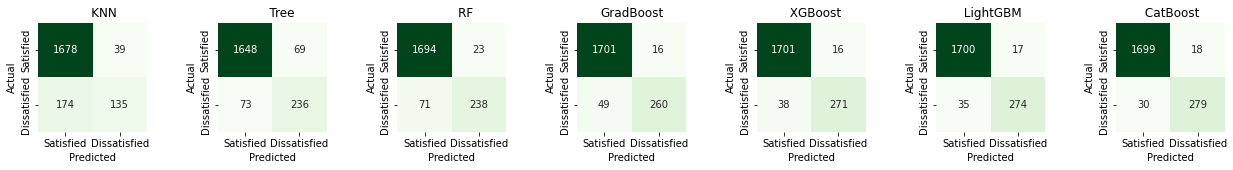

In [8]:
# Confusion matrices
plt.figure(figsize=(22, 2))

for i, name in enumerate(list(models.keys())):
    plt.subplot(1, 7, i + 1)
    sns.heatmap(results[i], annot=True, square=True, cbar=False, cmap='Greens', fmt='d',
                xticklabels=['Satisfied', 'Dissatisfied'], yticklabels=['Satisfied', 'Dissatisfied'])
    plt.title(name)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
plt.show()

The **CatBoost** is clearly the best model here.

What we want in this study is to identify the maximum of not satisfied customers before they stop using the bank services: in other words, we must maximize the recall.

We only miss 30 dissatisfied clients out of 309, so around 90% are identified.

However, there are still 18 satisfied customers who will receive new benefits because identified as dissatisfied. Lucky day for them!

Thank you for reading. Please let me know if you have any suggestion.

**Have a nice day!**